<a href="https://colab.research.google.com/github/shnhrtkyk/JTCcode/blob/main/03_%E4%BB%98%E9%8C%B2_ICP_point_to_plane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 点と面のマッチングによるICPアルゴリズムの実装

## コードのダウンロード

In [1]:
!wget http://graphics.stanford.edu/pub/3Dscanrep/bunny.tar.gz
!tar xvfz ./bunny.tar.gz

--2023-03-29 07:50:08--  http://graphics.stanford.edu/pub/3Dscanrep/bunny.tar.gz
Resolving graphics.stanford.edu (graphics.stanford.edu)... 171.67.77.70
Connecting to graphics.stanford.edu (graphics.stanford.edu)|171.67.77.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4894286 (4.7M) [application/x-gzip]
Saving to: ‘bunny.tar.gz’

bunny.tar.gz        100%[===================>]   4.67M  7.90MB/s    in 0.6s    

2023-03-29 07:50:09 (7.90 MB/s) - ‘bunny.tar.gz’ saved [4894286/4894286]

bunny/
bunny/data/
bunny/data/README
bunny/data/bun.conf
bunny/data/bun.conf~
bunny/data/bun000.ply
bunny/data/bun045.ply
bunny/data/bun090.ply
bunny/data/bun180.ply
bunny/data/bun270.ply
bunny/data/bun315.ply
bunny/data/chin.ply
bunny/data/ear_back.ply
bunny/data/top2.ply
bunny/data/top3.ply
bunny/reconstruction/
bunny/reconstruction/README
bunny/reconstruction/bun_zipper.ply
bunny/reconstruction/bun_zipper_res2.ply
bunny/reconstruction/bun_zipper_res3.ply
bunny/reconstruction/

## ライブラリインストール

In [2]:
!pip install open3d==0.16

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.7 MB/s eta 0:00:00
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.8.0
    Uninstalling nbformat-5.8.0:
      Successfully uninstalled nbformat-5.8.0


# Point-to-plane ICP

## 概要
ICPアルゴリズムは次の４つの手順を踏むことによって，ソース点群をターゲット点群へ位置合わせする剛体変換を算出します．

1. ソース点群とターゲット点群の対応付け
2. 剛体変換の推定
3. 物体の姿勢のアップデート
4. 収束判定（収束しない場合は1.へ戻る）

BeslとMackeyらの原著論文では，Step2において，点と点の距離を最小化する剛体変換を推定（Hornによる単位四元数を用いた方法）していました．
これに対して，少ない回数で収束させるよう改善した目的関数として，Point-to-planeが存在します．
Point-to-planeの目的関数では，ターゲットの表面に平面を仮定し，点と面の距離を評価します．
このために，ターゲット点群には単位法線ベクトルを割り当てておきます．
メッシュデータが元になるターゲットであれば，メッシュの法線方向を法線ベクトルとします．
センサからの計測データがターゲット点群の場合は，注目点の周りの点を使って法線ベクトルを計算することができます．

## Point-to-plane目的関数
Point-to-planeは，ソースの点とターゲットの面の距離を評価する目的関数です．
目的関数に入る前に，点$P$を${\bf p}=(x,y,z)^\top$，面を単位法線ベクトル${\bf n}_x$と面上の任意の点${\bf x}=(x_0, y_0, z_0)^\top$として，この距離について考えます．
距離は，点から面への最短距離，つまり点$P$から面へ伸ばした垂線の長さです．
これは，面上の任意の点から点$P$までのベクトル${\bf v} = (x-x_0, y-y_0, z-z_0)^\top$を${\bf n}_x$に射影したベクトルの長さになります．
したがって，

$d = |{\bf v}\cdot {\bf n}| = | ({\bf p}-{\bf x})\cdot {\bf n}_x|$

となります．

ICPにおいては，点$P$がソース点群を構成する点，点$X$と法線${\bf n}_x$がターゲット点群を構成する点です．
ソース点群は回転行列$R$と平行移動ベクトル$\bf t$による変換（これを同次変換行列$T$で表します．）を考慮すると，
Point-to-planeの目的関数は，次のように書くことができます．

$E({\bf T}) = \Sigma_{({\bf x},{\bf p})\in \mathcal{K}}(({\bf x}-{\bf Tp})\cdot{\bf n_x})^2$

この目的関数を使うと，多くの場合でPoint-to-pointの目的関数を利用したICPよりも少ない繰り返し回数で収束することが知られています．しかしながら，法線付きの点群を扱わなければならないことに注意しましょう．

本節では，Point-to-planeの目的関数を利用した剛体変換の推定方法を解説します．
point-to-planeの目的関数はpoint-to-pointのものと似ていますが，同様の方法で解くことができません．
そこで，ICPによる姿勢のアップデートが微小であると仮定して求めたい回転行列を線形化することによって，最小化問題を解析的に解くアプローチを取ります．

## 微小回転を仮定した回転行列の線形化


第2章で説明したロドリゲスの公式を変形すると回転軸$\bf w$，回転角$ \theta$による回転は次のように表すことができます．


\begin{equation}
\label{eq:theta_w_to_rotmat}
R(\theta,{\bf w}) = I_3 + sin\theta W + (1-cos\theta)W^2
\end{equation}
ここで，行列$W$はベクトル$\bf w$による外積を行列積として計算するための歪対称行列です．

\begin{equation}
W = 
\begin{bmatrix}
0 & -w_3 & w_2\\
w_3 & 0 & -w_1\\
-w_2 & w_1 & 0\\
\end{bmatrix}
\end{equation}

$\bf w$と$ \theta$に微小な変動のみを仮定すると，$sin \theta\approx\theta, cos\theta\approx 1$なので，回転行列が

\begin{equation}
R(\theta,{\bf w}) \approx I_3 + \theta W = I_3 + 
\begin{bmatrix}
0 & -\theta w_3 & \theta w_2\\
\theta w_3 & 0 & -\theta w_1\\
-\theta w_2 & \theta w_1 & 0\\
\end{bmatrix}
\end{equation}

となります．

ここで，${\bf a} = \theta {\bf w}$とするベクトルを導入すると，

\begin{equation}
R(\theta,{\bf w}) = I_3 + 
\begin{bmatrix}
0 & -a_3 & a_2\\
a_3 & 0 & -a_1\\
-a_2 & a_1 & 0\\
\end{bmatrix}
\end{equation}

この式は任意の3次元ベクトル$\bf p$を使った外積で書き直せます．

$R(\theta,{\bf w}){\bf p} = {\bf p} + {\bf a}\times{\bf p} $

## Point-to-plane目的関数の変形
目的関数に線形化した回転行列を代入します．

\begin{equation}
E({\bf a,t}) = \Sigma_{({\bf x},{\bf p})\in \mathcal{K}}(( {\bf p} + {\bf a}\times{\bf p} + {\bf t} - {\bf x}  )\cdot{\bf n}_x)^2
\end{equation}

次に，未知の要素を6次元ベクトル${\bf u}^\top = [{\bf a}^\top {\bf t}^\top]$でまとめて，スカラー三重積の性質に注意しながら，目的関数の括弧内を展開します．



\begin{equation}
E({\bf a,t}) = \sum_{({\bf x},{\bf p})\in \mathcal{K}}( ({\bf p}\times{\bf n}_x)^\top{\bf a} + {\bf n}_x^\top{\bf t} - {\bf n}_x^\top( {\bf x}-{\bf p} ))^2
\end{equation}

\begin{equation}
E({\bf u}) = \sum_{({\bf x},{\bf p})\in \mathcal{K}}( [({\bf p}\times{\bf n}_x)^\top  {\bf n}_x^\top]{\bf u} - {\bf n}_x^\top( {\bf x}-{\bf p} ))^2
\end{equation}

\begin{equation}
\begin{split}
E({\bf u}) =  & {\bf u}^\top\underbrace{(\Sigma_{({\bf x},{\bf p})\in \mathcal{K}}
\begin{bmatrix}
({\bf p}\times{\bf n}_x) \\
{\bf n}_x \\
\end{bmatrix} 
\begin{bmatrix}
[({\bf p}\times{\bf n}_x)^\top & {\bf n}_x^\top]
\end{bmatrix})}_{A \in \mathbb{R}^{6\times 6}}{\bf u} \\
 &-2{\bf u}^\top\underbrace{(\Sigma_{({\bf x},{\bf p})\in \mathcal{K}}
\begin{bmatrix}
({\bf p}\times{\bf n}_x) \\
{\bf n}_x \\
\end{bmatrix}{\bf n}_x^\top( {\bf x}-{\bf p} ) )}_{{\bf b} \in \mathbb{R}^6} \\
& +\underbrace{(\Sigma_{({\bf x},{\bf p})\in \mathcal{K}}( {\bf x}-{\bf p} )^\top{\bf n}_x{\bf n}_x^\top( {\bf x}-{\bf p} ))}_{constant}
\end{split}
\end{equation}

第１項の括弧内を6x6行列$A$，第２項の括弧内を6次元ベクトル$\bf b$とすると，$\bf u$に関する二次形式の最小化問題が見えてきます．

\begin{equation}
{\bf u}^\top A{\bf u}-2{\bf u}^\top{\bf b}
\end{equation}

この解は
${\bf u}^*=A^{-1}{\bf b}$
です．
${\bf u}$の前半3つの成分が回転成分$\bf a$，後半3つが平行移動ベクトル${\bf t}$です．
$\bf a$を回転軸と回転角度に戻すために，$\theta = ||{\bf a}||$, ${\bf w} = {\bf a}/\theta$を計算します．
これらを式(4.20)に代入するとPoint-to-planeで計算した回転行列が得られます．


## Point-to-plane ICPの実装

それでは，Point-to-planeの目的関数による回転行列，平行移動ベクトルの推定を実装しましょう．
実装が必要なのは$A^{-1}$と${\bf b}$です．

まずは位置合わせ対象の点群を読み込みます．ソース点群$P$を変数名```pcd_s```，ターゲット点群$X$を変数名```pcd_t```としてデータを用意します．
ビューワーが立ち上がったら，[n]キーを押下してみてください．ターゲット点群に法線が割り当てられていることを確認できます．

In [15]:
import open3d as o3d
import numpy as np
import copy

pcd1 = o3d.io.read_point_cloud( "/content/bunny/data/bun000.ply" )
pcd2 = o3d.io.read_point_cloud( "/content/bunny/data/bun045.ply" )

pcd_s = pcd1.voxel_down_sample(voxel_size=0.003)
pcd_t = pcd2.voxel_down_sample(voxel_size=0.003)

pcd_s.paint_uniform_color([0.0, 1.0, 0.0])
pcd_t.paint_uniform_color([0.0, 0.0, 1.0])

# Estimation of normal vector of points
pcd_s.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# Estimation of normal vector of points
pcd_t.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

o3d.visualization.draw_plotly(
  [pcd_s, pcd_t],
  width=1200,
  height=800
)

次に，ICPアルゴリズムのStep1を実装します．
この処理は最近傍探索ですが，近傍点の法線群である```np_normal_y```を取り出す処理が追加されています．

In [17]:
pcd_tree = o3d.geometry.KDTreeFlann(pcd_t)


idx_list = []
for i in range(len(pcd_s.points)):
    [k, idx, _] = pcd_tree.search_knn_vector_3d(pcd_s.points[i], 1)
    idx_list.append(idx[0])

np_pcd_t = np.asarray(pcd_t.points)
np_pcd_y = np_pcd_t[idx_list].copy()
np_normal_t = np.asarray(pcd_t.normals)
np_normal_y = np_normal_t[idx_list].copy()

続いてStep2の実装です．
行列$A$とベクトル$\bf b$を計算します．次のコードでは，見やすさのためにそれぞれ別のfor文で計算していますが，
まとめて計算することもできます．

In [18]:
#  Matrix A
np_pcd_s = np.asarray(pcd_s.points)
A = np.zeros((6,6))
for i in range(len(np_pcd_s)):
    xn = np.cross( np_pcd_s[i], np_normal_y[i] ) 
    xn_n = np.hstack( (xn, np_normal_y[i]) ).reshape(-1,1)
    A += np.dot( xn_n, xn_n.T )
print(A)

[[ 1.08650013e+01  4.46652396e-01  5.35931999e+00 -6.08242252e+01
   2.49686450e+01  9.32307850e+01]
 [ 4.46652396e-01  1.30042247e+00 -1.14575111e+00  1.33804488e+01
  -3.63365948e-01 -7.45935677e+00]
 [ 5.35931999e+00 -1.14575111e+00  1.33934155e+01 -1.25114295e+02
   9.43256616e-01  6.11875912e+01]
 [-6.08242252e+01  1.33804488e+01 -1.25114295e+02  1.39073266e+03
  -1.73141721e+02 -7.34616631e+02]
 [ 2.49686450e+01 -3.63365948e-01  9.43256616e-01 -1.73141721e+02
   1.00155008e+03  3.26956665e+02]
 [ 9.32307850e+01 -7.45935677e+00  6.11875912e+01 -7.34616631e+02
   3.26956665e+02  1.06671726e+03]]


In [19]:
# Vector b
b = np.zeros((6,1))
for i in range(len(np_pcd_s)):
    xn = np.cross( np_pcd_s[i], np_normal_y[i] ) 
    xn_n = np.hstack( (xn, np_normal_y[i]) ).reshape(-1,1)
    nT = np_normal_y[i].reshape(1,-1)
    p_x = (np_pcd_y[i] - np_pcd_s[i] ).reshape(-1,1)
    b += xn_n * np.dot(nT,p_x)
print(b)

[[-0.32278787]
 [-0.33856293]
 [-1.96162435]
 [20.89946741]
 [ 6.72666002]
 [ 3.03192802]]


$A$の逆行列と$\bf b$の積を計算し，回転軸$\bf w$と回転量$\theta$を計算します．

In [20]:
# 回転軸wと回転量thetaの算出
u_opt = np.dot(np.linalg.inv(A),b)
theta = np.linalg.norm(u_opt[:3])
w = (u_opt[:3]/theta).reshape(-1)
print('w:',w)
print('theta:', theta)

w: [-0.26627554 -0.94543259  0.18776194]
theta: 0.39120431413835116


$\bf w$と$\theta$から，回転行列を計算します．

In [21]:
def axis_angle_to_matrix( axis, theta ):
    """
    Args:
      axis(ndarray): rotation axis
      theta(float): rotation angle
    """
    
    # 歪対象行列
    w = np.array([[     0.0, -axis[2],  axis[1]],
                  [ axis[2],      0.0, -axis[0]],
                  [-axis[1],  axis[0],      0.0]
                 ])
    rot = np.identity(3) + (np.sin(theta)*w) \
                                       + ((1-np.cos(theta))*np.dot(w,w))
    return rot

rot = axis_angle_to_matrix( w, theta )
print(rot)

[[ 0.92980718 -0.05257476 -0.36427256]
 [ 0.09061325  0.99197988  0.08812014]
 [ 0.35671816 -0.11494266  0.92711399]]


```u_opt```の後半３つの要素が平行移動ベクトルであることに注意して，同次変換行列を作成します．

In [22]:
# 4x4同次変換行列の算出
transform = np.identity(4)
transform[0:3,0:3] = rot.copy()
transform[0:3,3] = u_opt[3:6].reshape(-1).copy()
print(transform)

[[ 0.92980718 -0.05257476 -0.36427256  0.0363497 ]
 [ 0.09061325  0.99197988  0.08812014  0.0061576 ]
 [ 0.35671816 -0.11494266  0.92711399  0.02829251]
 [ 0.          0.          0.          1.        ]]


得られた変換行列をソース点群に適用します．これを赤色の点群として，表示します．

In [23]:
# 変換前後の点群の表示．
pcd_s2 = copy.deepcopy(pcd_s)
pcd_s2.transform(transform)
pcd_s2.paint_uniform_color([1.0,0.0,0.0])


o3d.visualization.draw_plotly(
  [pcd_t, pcd_s, pcd_s2],
  width=1200,
  height=800
)

ターゲット点群に近づいたことがわかりました．
これ以降は，4.4.3節，4.4.4節の手続きを踏むことによって，ICPアルゴリズムを動作させることができます．

Point-to-plane型ICPアルゴリズムの処理を一つのクラス（ICPRegistration_PointToPlane）として実装したサンプルコードは，\sf{icp\_registration.py}にあります．
このクラスを利用してICPをおこなうサンプルコードの実行方法は次の通りです．第一引数に１を指定してください．

```bash
python run_my_icp.py 1
```

## ICPRegistrationクラスのテスト
Point-to-PlaneとPoint-to-Pointの収束性能を比較します．

In [24]:
import time
import copy
import numpy as np
import numpy.linalg as LA
import open3d as o3d

class ICPRegistration_PointToPoint:
    # input source, target
    def __init__( self, pcd_s, pcd_t ):
        self.pcd_s = copy.deepcopy(pcd_s)
        self.pcd_t = copy.deepcopy(pcd_t)
        self.n_points = len(self.pcd_s.points)
        
        self.pcds = []
        self.d = []
        self.closest_indices = []
        self.final_trans = np.identity(4)
        self.n_iteration = 30
        self.th_distance = 0.001
        self.th_ratio = 0.999
        
        # 初期化ステップ
        ## レジストレーションベクトル
        self.q = np.array([1.,0.,0.,0.,0.,0.,0.])
        
        self.pcd_tree = o3d.geometry.KDTreeFlann(self.pcd_t)
        self.np_pcd_t = np.asarray(self.pcd_t.points)

    def set_n_iterations( self, n ):
        self.n_iteration = n

    def set_th_distance( self, th ):
        self.th_distance = th

    def set_th_ratio( self, th ):
        self.th_ratio = th
        
    def closest_points( self ):
        idx_list = []
        distance = []
        for i in range(self.n_points):
            [k, idx, d] = self.pcd_tree.search_knn_vector_3d(self.pcd_s.points[i], 1)
            idx_list.append(idx[0])
            distance.append(d[0])

        np_pcd_y = self.np_pcd_t[idx_list]
        self.closest_indices.append( idx_list )
        self.d.append( np.sqrt(np.mean(np.array(distance))) )
        return np_pcd_y.copy()
    
    def compute_registration_param( self, np_pcd_y ):
        # 重心の取得
        mu_s = self.pcd_s.get_center()
        mu_y = np.mean(np_pcd_y, axis=0)

        # 共分散行列の計算
        np_pcd_s = np.asarray(self.pcd_s.points)
        covar = np.zeros( (3,3) )
        n_points = np_pcd_s.shape[0]
        for i in range(n_points):
            covar += np.dot( np_pcd_s[i].reshape(-1, 1), np_pcd_y[i].reshape(1, -1) )
        covar /= n_points
        covar -= np.dot( mu_s.reshape(-1,1), mu_y.reshape(1,-1) )
        
        ## anti-symmetrix matrix
        A = covar - covar.T
        delta = np.array([A[1,2],A[2,0],A[0,1]])
        tr_covar = np.trace(covar)
        i3d = np.identity(3)
        
        # symmetric matrixの作成
        Q = np.zeros((4,4))
        Q[0,0] = tr_covar
        Q[0,1:4] = delta
        Q[1:4,0] = delta
        Q[1:4,1:4] = covar + covar.T - tr_covar*i3d
        
        w, v = LA.eig(Q)
        rot = self.quaternion2rotation(v[:,np.argmax(w)])
        trans = mu_y - np.dot(rot,mu_s)
        
        self.q = np.concatenate((v[np.argmax(w)],trans))
        transform = np.identity(4)
        transform[0:3,0:3] = rot.copy()
        transform[0:3,3] = trans.copy()
        return transform
    
        
    def registration( self ):
        
        for i in range(self.n_iteration):
            # Step. 1
            np_pcd_y = self.closest_points()
            # Step. 2
            transform = self.compute_registration_param( np_pcd_y )
            # Step. 3
            self.pcd_s.transform(transform)
            self.final_trans = np.dot(transform,self.final_trans)
            self.pcds.append(copy.deepcopy(self.pcd_s))
            # Step. 4
            if ((2<i) and (self.th_ratio < self.d[-1]/self.d[-2])) or (self.d[-1] < self.th_distance):
                break
        
        return self.pcd_s
        
    # 四元数を回転行列に変換する
    def quaternion2rotation( self, q ):
        rot = np.array([[q[0]**2+q[1]**2-q[2]**2-q[3]**2, 
                         2.0*(q[1]*q[2]-q[0]*q[3]), 
                         2.0*(q[1]*q[3]+q[0]*q[2])],

                        [2.0*(q[1]*q[2]+q[0]*q[3]),
                        q[0]**2+q[2]**2-q[1]**2-q[3]**2,
                         2.0*(q[2]*q[3]-q[0]*q[1])],

                        [2.0*(q[1]*q[3]-q[0]*q[2]),
                         2.0*(q[2]*q[3]+q[0]*q[1]),
                        q[0]**2+q[3]**2-q[1]**2-q[2]**2]]
                      )
        return rot

class ICPRegistration_PointToPlane:
    # input source, target
    def __init__( self, pcd_s, pcd_t ):
        self.pcd_s = copy.deepcopy(pcd_s)
        self.pcd_t = copy.deepcopy(pcd_t)
        self.n_points = len(self.pcd_s.points)
        
        self.pcds = []
        self.d = []
        self.closest_indices = []
        self.final_trans = np.identity(4)
        self.n_iteration = 30
        self.th_distance = 0.001
        self.th_ratio = 0.999
        
        self.pcd_tree = o3d.geometry.KDTreeFlann(self.pcd_t)
        self.np_pcd_t = np.asarray(self.pcd_t.points)
        self.np_normal_t = np.asarray(self.pcd_t.normals)
    
    def set_n_iterations( self, n ):
        self.n_iterations = n
    
    def set_th_distance( self, th ):
        self.th_distance = th

    def set_th_ratio( self, th ):
        self.th_ratio = th
    
    def closest_points( self ):
        idx_list = []
        distance = []
        for i in range(self.n_points):
            [k, idx, d] = self.pcd_tree.search_knn_vector_3d(self.pcd_s.points[i], 1)
            idx_list.append(idx[0])
            distance.append(d[0])

        np_pcd_y = self.np_pcd_t[idx_list]
        np_normal_y = self.np_normal_t[idx_list]
        self.closest_indices.append( idx_list )
        self.d.append( np.sqrt(np.mean(np.array(distance))) )
        return np_pcd_y.copy(), np_normal_y.copy()
    
    def compute_registration_param( self, np_pcd_y, np_normal_y ):
        
        # A,bの計算
        np_pcd_s = np.asarray(self.pcd_s.points)
        A = np.zeros((6,6))
        b = np.zeros((6,1))
        for i in range(len(np_pcd_s)):
            xn = np.cross( np_pcd_s[i], np_normal_y[i] ) 
            xn_n = np.hstack( (xn, np_normal_y[i]) ).reshape(-1,1)
            A += np.dot( xn_n, xn_n.T )
            
            nT = np_normal_y[i].reshape(1,-1)
            p_x = (np_pcd_y[i] - np_pcd_s[i] ).reshape(-1,1)
            b += xn_n * np.dot(nT,p_x)
            
            
        u_opt = np.dot(np.linalg.inv(A),b)
        theta = np.linalg.norm(u_opt[:3])
        w = (u_opt[:3]/theta).reshape(-1)
        rot = self.axis_angle_to_matrix( w, theta )
        
        transform = np.identity(4)
        transform[0:3,0:3] = rot.copy()
        transform[0:3,3] = u_opt[3:6].reshape(-1).copy()
        
        return transform
    
    # main processing    
    def registration( self ):
        
        for i in range(self.n_iterations):
            # Step 1.
            np_pcd_y, np_normal_y = self.closest_points()
            # Step 2.
            transform = self.compute_registration_param( np_pcd_y, np_normal_y )
            # Step 3.
            self.pcd_s.transform(transform)
            self.final_trans = np.dot(transform,self.final_trans)
            self.pcds.append(copy.deepcopy(self.pcd_s))
            # Step 4.
            if ((2<i) and (self.th_ratio < self.d[-1]/self.d[-2])) or (self.d[-1] < self.th_distance):
                break
        
        return self.pcd_s
        
    def axis_angle_to_matrix( self, axis, theta ):
        """
        Args:
          axis(ndarray): rotation axis
          theta(float): rotation angle
        """

        # make skew-symmetric cross product matrix 
        w = np.array([[     0.0, -axis[2],  axis[1]],
                      [ axis[2],      0.0, -axis[0]],
                      [-axis[1],  axis[0],      0.0]
                     ])
        return np.identity(3) + (np.sin(theta)*w) + ((1-np.cos(theta))*np.dot(w,w))


def get_correspondence_lines( pcd_s, pcd_t, idx_list ):
    
    # make point cloud pair
    np_pcd_s = np.asarray(pcd_s.points)
    np_pcd_t = np.asarray(pcd_t.points)
    np_pcd_pair = np.concatenate((np_pcd_s,np_pcd_t))

    # choose pairing ids
    lines = list()
    n_points = len(pcd_s.points)
    for i in range(n_points):
        lines.append([i,n_points+idx_list[i]])

    # make lineset    
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(np_pcd_pair),
        lines=o3d.utility.Vector2iVector(lines),
    )
    return line_set

def visualize_icp_progress( reg ):

    pcds = reg.pcds
    indices = reg.closest_indices
    pcd_t = reg.pcd_t

    cnt = 0
    pcd = o3d.geometry.PointCloud()
    line_set = o3d.geometry.LineSet()
    def reg( vis ):
        nonlocal cnt
        
        pcd.points = pcds[cnt].points
        pcd.paint_uniform_color([1.0,0.0,0.0])
        lines = get_correspondence_lines( pcds[cnt], pcd_t, indices[cnt] )
        line_set.lines = lines.lines
        line_set.points = lines.points
        vis.update_geometry( pcd )
        vis.update_geometry( line_set )
        
        cnt+=1
        time.sleep(0.3)
        if  len(pcds)-1 <= cnt:
            cnt = 0
    

    o3d.visualization.draw_plotly(
  [pcd, pcd_t, line_set],
  width=1200,
  height=800
)

In [27]:
pcd1 = o3d.io.read_point_cloud( "/content/bunny/data/bun000.ply" )
pcd2 = o3d.io.read_point_cloud( "/content/bunny/data/bun045.ply" )

pcd_s = pcd1.voxel_down_sample(voxel_size=0.003)
pcd_t = pcd2.voxel_down_sample(voxel_size=0.003)

# Estimation of normal vector of points
pcd_s.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# Estimation of normal vector of points
pcd_t.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# ICPの実行．
reg1 = ICPRegistration_PointToPoint(pcd_s, pcd_t)
reg2 = ICPRegistration_PointToPlane(pcd_s, pcd_t)
reg1.set_th_distance( 0.003 )
reg1.set_n_iterations( 100 )
reg1.set_th_ratio( 0.999 )
pcd_reg1 = reg1.registration()

reg2.set_th_distance( 0.003 )
reg2.set_n_iterations( 100 )
reg2.set_th_ratio( 0.999 )
pcd_reg2 = reg2.registration()


pcd_reg1.paint_uniform_color([0.0, 1.0, 0.0])
pcd_reg2.paint_uniform_color([0.0, 0.0, 1.0])
o3d.visualization.draw_plotly(
  [pcd_reg1, pcd_reg2],
  width=1200,
  height=800
)

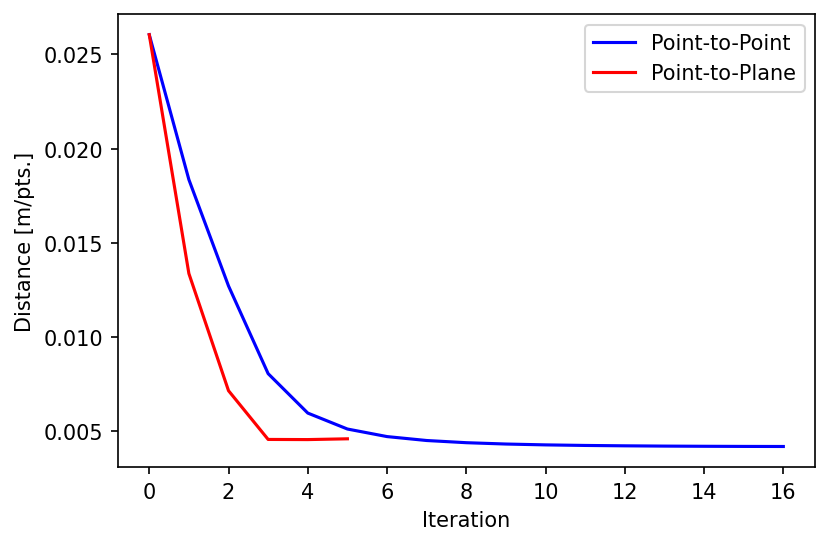

In [28]:
# 誤差のプロット
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(dpi=150)
plt.ylabel("Distance [m/pts.]")
plt.xlabel("Iteration")
plt.plot(reg1.d, c="b")
plt.plot(reg2.d, c="r")
plt.legend(labels=["Point-to-Point","Point-to-Plane"])
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))

plt.savefig("reg_error_compared.png")

図は，Point-to-pointとPoint-to-planeの繰り返し演算における位置ずれ誤差の推移です．
Point-to-planeのほうが少ない回数で繰り返し演算が収束したことが分かります．